In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [36]:
df = pd.read_csv("AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [38]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [39]:
df["Month"] = pd.to_datetime(df["Month"])

df.rename(columns={"#Passengers":"Passengers"},inplace=True)
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


# Exploratory Data Analysis (EDA)

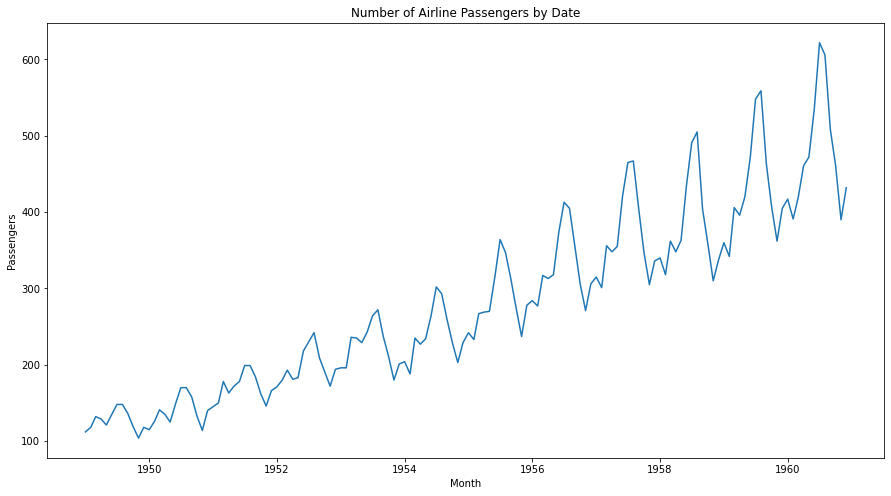

In [40]:
plt.figure(figsize=(15,8))
plt.title("Number of Airline Passengers by Date")
sns.lineplot(x="Month",y="Passengers",data=df);

In [41]:
df_year = df.copy()

df_year["Year"] = df["Month"].dt.year
df_year = df_year.drop("Month",axis=1)
df_year.head()

,Passengers,Year
0,112,1949
1,118,1949
2,132,1949
3,129,1949
4,121,1949


In [42]:
df_year_group = df_year.groupby("Year")[["Passengers"]].mean()
df_year_group

,Passengers
Year,
1949,126.666667
1950,139.666667
1951,170.166667
1952,197.000000
1953,225.000000
1954,238.916667
1955,284.000000
1956,328.250000
1957,368.416667


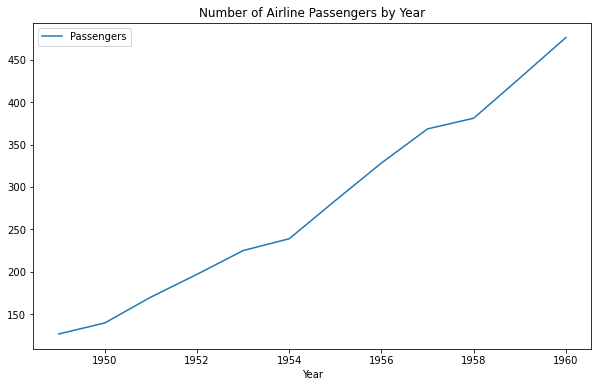

In [71]:
plt.figure(figsize=(10,6))
plt.title("Number of Airline Passengers by Year")
sns.lineplot(data=df_year_group);

In [44]:
df_month = df.copy()

df_month["Month"] = df["Month"].dt.month
df_month.head()

,Month,Passengers
0,1,112
1,2,118
2,3,132
3,4,129
4,5,121


In [45]:
df_month_group = df_month.groupby("Month")[["Passengers"]].mean()
df_month_group

,Passengers
Month,
1,241.750000
2,235.000000
3,270.166667
4,267.083333
5,271.833333
6,311.666667
7,351.333333
8,351.083333
9,302.416667


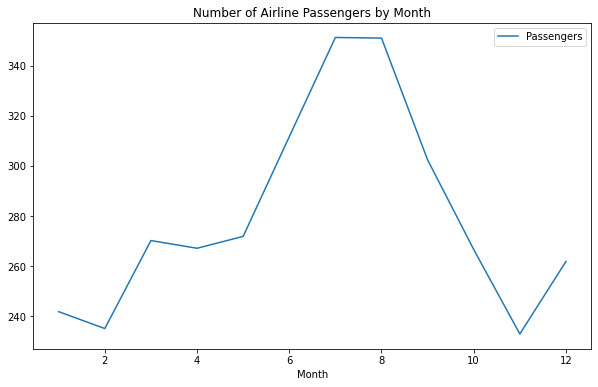

In [72]:
plt.figure(figsize=(10,6))
plt.title("Number of Airline Passengers by Month")
sns.lineplot(data=df_month_group);

# Time Series Decomposing

A time series become of four component. These components are level, trend, seasonality and noise.

Level: The average value in the series.

Trend: The increasing or decreasing value in the series.

Seasonality: The repeating short-term cycle in the series.

Noise: The random variation in the series.


The combination of the components in time series can be of two types:

- Additive
- Multiplicative


if the components of the time series are added together to make the time series. Then the time series is called the additive time series. By visualization, we can say the time series is additive if the increasing or decreasing pattern of the time series is similar throughout the series.

y(t) = level + Trend + seasonality + noise

If the components of the time series are multiplicative together, then the time series is called the multiplicative time series. By visualization, if the time series is having exponential growth or decrement with time then the time series can be considered as the multiplicative time series.

y(t) = Level * Trend * seasonality * Noise

In [48]:
df = df.set_index("Month")
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


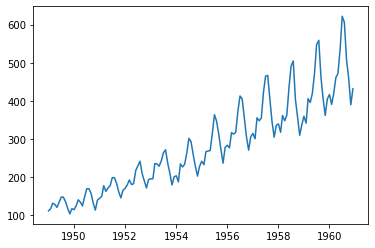

In [49]:
plt.plot(df)

According to the graph above, the data is multiplicative.

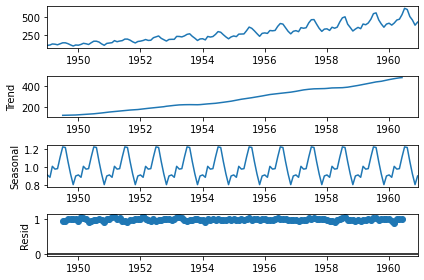

<Figure size 648x432 with 0 Axes>

In [50]:
decompose = sm.tsa.seasonal_decompose(df,model="multiplicative")
decompose.plot()
plt.figure(figsize=(9,6))
plt.show()

We can clearly see by visualization that there is trend and season is present in the time series

# Stationary

A stationary time series is one whose properties do not depend on the time at which the series is observed. So, time series with trends, or with seasonality, are not stationary.

Let's check the data is stationary or not. There are many ways to known this. 
- Rolling Mean
- ACF
- Augmented Dickey–Fuller Test (ADF)
- Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS)  


A rolling average is a great way to visualize how the dataset is trending. We will also include the rolling standard deviation to see how much the data varies from the rolling average.

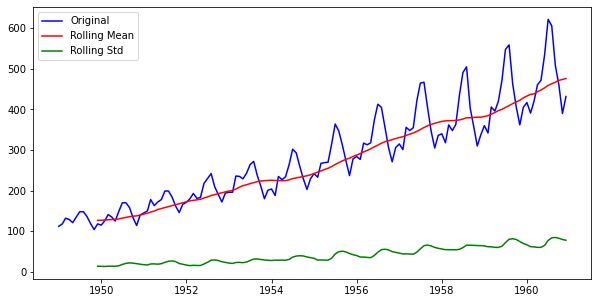

In [52]:
rolling_mean = df["Passengers"].rolling(window = 12).mean()
rolling_std = df["Passengers"].rolling(window = 12).std()
plt.figure(figsize=(10,5))
plt.plot(df, color = "blue", label = "Original")
plt.plot(rolling_mean, color= "red", label = "Rolling Mean")
plt.plot(rolling_std, color = "green", label = "Rolling Std")
plt.legend(loc= "best")
plt.show()

# Augmented Dickey–Fuller Test

Augmented Dickey–Fuller Test is used to determine data is stationary or not. The test return four value which are ADF test statistic, p-value, lag and number of observation. 

If p-value <=0.05 data is stationary.

H0: Data is not stationary.

H1: Data is stationary.

In [53]:
def adfuller_test(passenger):
  test_result = adfuller(passenger)

  labels = ['ADF Test Statistic','p-value','Lag','Number of Observation']

  for label,result in zip(labels,test_result):
    print(label + " : " + str(result))

  if test_result[1] <= 0.05:
    print("Data is stationary.")
  else:
    print("Data is not stationary.")

In [54]:
adfuller_test(df["Passengers"])

ADF Test Statistic : 0.8153688792060604
p-value : 0.9918802434376413
Lag : 13
Number of Observation : 130
Data is not stationary.


When time series has trend or seasonality the data  is non-stationary.

# Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS)  

KPSS test is commonly used for stationary. A very important point is that the interpretation of KPSS is entirely opposite of the ADF.

H0: The time series is stationary.

H1: The time series is not stationary.

If the p-value <= 0.05 the absolute value of the test statistics is greater than the critical value, data  is not stationary. So you reject the H0 hypothesis.

If the p-value > 0.05 or the absolute value of the test statistics is less than the critical value, data is stationary. 

In [55]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [56]:
kpss_test(df)

KPSS Statistic: 1.6513122354165206
p-value: 0.01
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


c:\Users\muser\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


# Converting non-stationary data to stationary data

There are certain transformation techniques.
- Differencing
- Log transforming of the data
- Taking the square root of the data
- Taking the cube root
- Proportional change

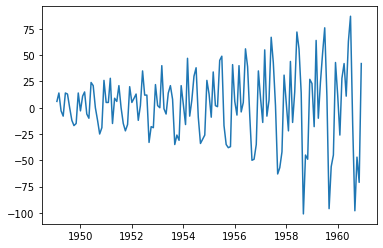

In [57]:
#Differencing
df_diff = df.diff()
plt.plot(df_diff)


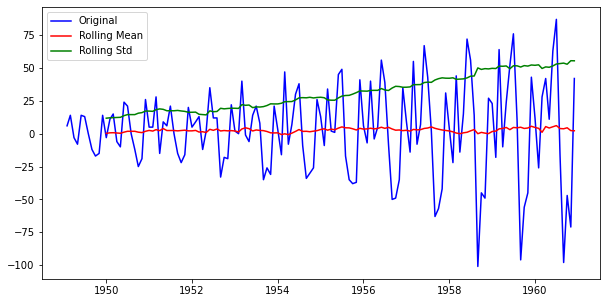

In [58]:
rolling_mean = df_diff["Passengers"].rolling(window = 12).mean()
rolling_std = df_diff["Passengers"].rolling(window = 12).std()
plt.figure(figsize=(10,5))
plt.plot(df_diff, color = "blue", label = "Original")
plt.plot(rolling_mean, color= "red", label = "Rolling Mean")
plt.plot(rolling_std, color = "green", label = "Rolling Std")
plt.legend(loc= "best")
plt.show()

In [59]:
adfuller_test(df_diff.dropna())

ADF Test Statistic : -2.8292668241699888
p-value : 0.054213290283826945
Lag : 12
Number of Observation : 130
Data is not stationary.


In [60]:
kpss_test(df_diff.dropna())

KPSS Statistic: 0.023897614400183963
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


c:\Users\muser\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Case 1: Both tests conclude that the series is not stationary - The series is not stationary

Case 2: Both tests conclude that the series is stationary - The series is stationary

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

As we known, d is the number of nonseasonal differences. We applied one differencing so, the value of d is 1 .

# ACF - PACF

Let's determine the values of p and q. ACF plot will help us to finding the value of p and PACF plot will help us to finding the value of q.

For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly. 

According to Autocorrelation graph, the data is non stationary which is already known that by the statistical test.

c:\Users\muser\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


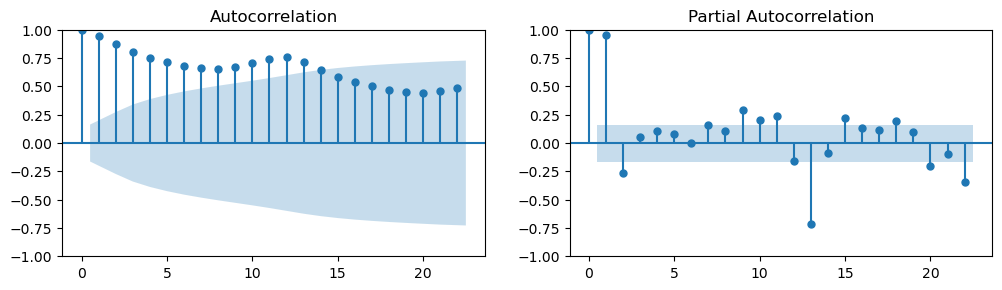

In [61]:
fig, axes = plt.subplots(1,2,figsize=(12,3), dpi= 100)
plot_acf(df['Passengers'],  ax=axes[0]);
plot_pacf(df['Passengers'],  ax=axes[1]);

c:\Users\muser\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


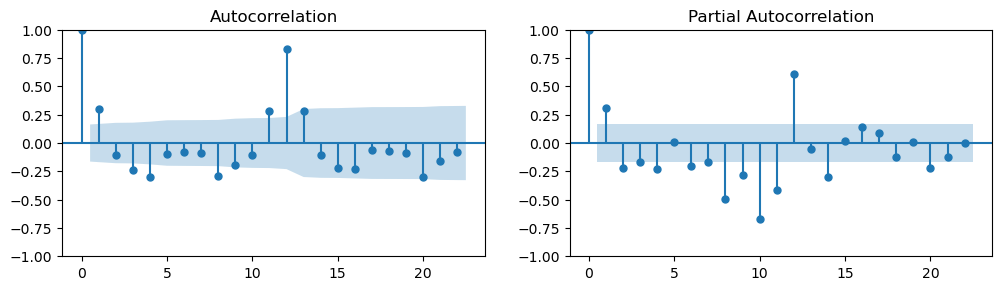

In [62]:
fig, axes = plt.subplots(1,2,figsize=(12,3), dpi= 100)
plot_acf(df_diff['Passengers'].dropna(),  ax=axes[0]);
plot_pacf(df_diff['Passengers'].dropna(),  ax=axes[1]);

Using the PACF plot, we can see first lag and second lag are significantly out of the limit so we can select the order of the p as 1. 

Using the ACF plot, we can see that 2 of the lags are out of the significance limit so we can say that the optimal value of your q is 2. 

c:\Users\muser\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\muser\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


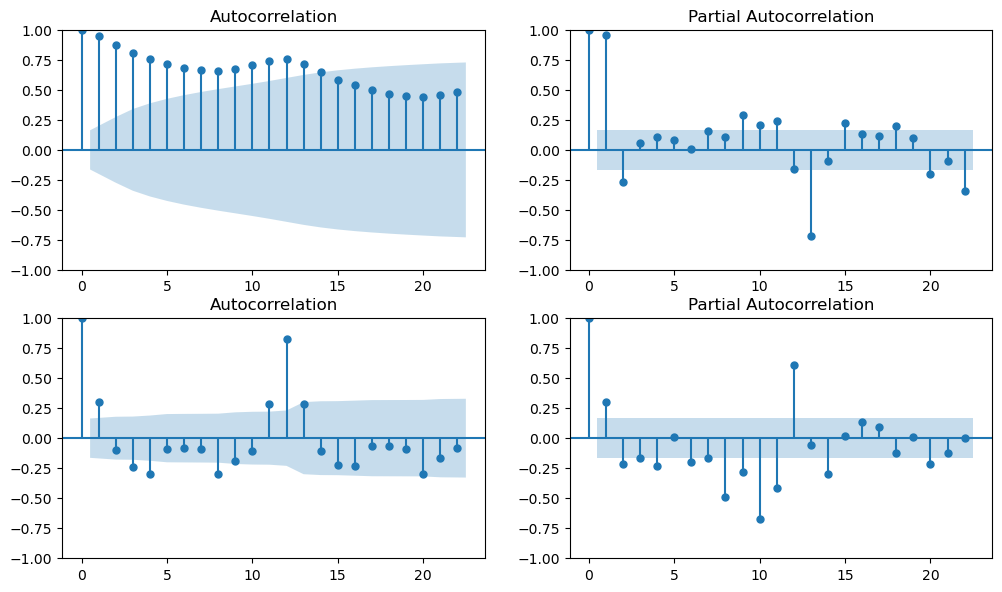

In [63]:
fig, axes = plt.subplots(2,2,figsize=(12,7), dpi= 100)
plot_acf(df['Passengers'],  ax=axes[0,0]);
plot_pacf(df['Passengers'],  ax=axes[0,1]);
plot_acf(df_diff['Passengers'].dropna(),  ax=axes[1,0]);
plot_pacf(df_diff['Passengers'].dropna(),  ax=axes[1,1]);

# Arima

Plotting ARIMA model


c:\Users\muser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\muser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\muser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


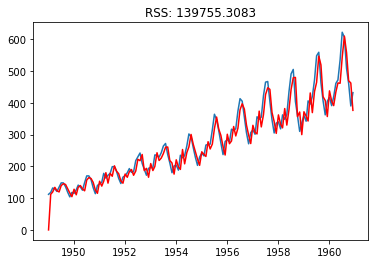

In [64]:
model_arima = ARIMA(df, order=(1,1,2)) #(p,d,q)
results_ARIMA = model_arima.fit()
plt.plot(df)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df['Passengers'])**2))
print('Plotting ARIMA model')

# Sarima

We try Auto-Arima for the SARIMA model. Before we start, let's learn differences between Auto-Arima and  Arima models. When we build an ARIMA model, we pass the p,d, and q values. We use statistical plots and techniques to find the optimal values of these parameters. Auto ARIMA automatically generates the optimal parameter values (p,d, and q). The generated values are the best, and the model will give accurate forecast results.

In [65]:
auto_arima_model = pm.auto_arima(df, 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12, #12 is the frequncy of the cycle
                      d=None,# let model determine 'd'
                      D=1, #order of the seasonal differencing
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
print(auto_arima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Wed, 31 Aug 2022   AIC                           1019.178
Time:                                     14:07:24   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

The model gave us values of the parameters which are (0,1,1)x(2,1,[],12).

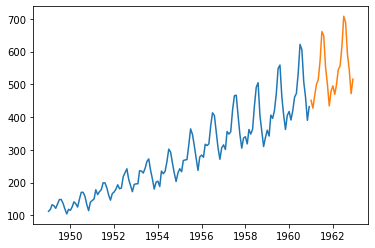

In [66]:
pred_sarima = auto_arima_model.predict(n_periods=24)
index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = 24, freq='MS')
fitted_series = pd.Series(pred_sarima, index=index_of_fc)
plt.plot(df)
plt.plot(fitted_series)

Also try the sarima from stats model.

c:\Users\muser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\muser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


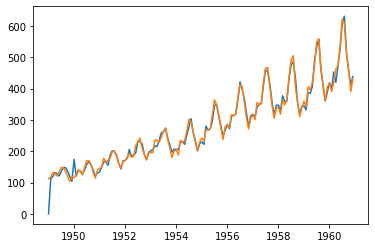

In [67]:
sarima = SARIMAX(df['Passengers'], 
                order=(0,1,1), 
                seasonal_order=(2,1,0,12))
predictions = sarima.fit().predict()

plt.plot(predictions)
plt.plot(df)

In [68]:
import pmdarima as pm
ARIMA_model = pm.auto_arima(df, 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -699.125
Date:                Wed, 31 Aug 2022   AIC                           1408.249
Time:                        14:07:26   BIC                           1423.098
Sample:                    01-01-1949   HQIC                          1414.283
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.6007     12.051      1.627      0.104      -4.018      43.219
ar.L1          0.4990      0.131      3.822      0.000       0.243       0.755
ar.L2          0.4314      0.124      3.466      0.0

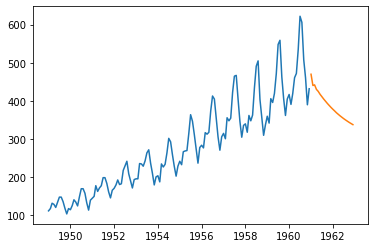

In [69]:
pred = ARIMA_model.predict(n_periods=24)
index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = 24, freq='MS')
fitted_series = pd.Series(pred, index=index_of_fc)
plt.plot(df)
plt.plot(fitted_series)

Plotting ARIMA model


c:\Users\muser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\muser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\muser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


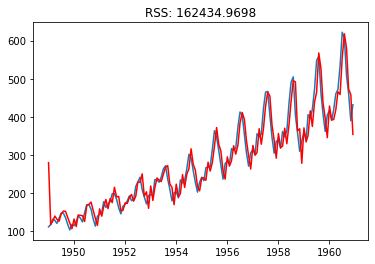

In [70]:
model_arima = ARIMA(df, order=(2,0,1))
results_ARIMA = model_arima.fit()
plt.plot(df)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df['Passengers'])**2))
print('Plotting ARIMA model')